In [1]:
!git clone https://github.com/uonat/SS2023_DI-Lab_Precitaste.git

Cloning into 'SS2023_DI-Lab_Precitaste'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 294 (delta 108), reused 230 (delta 62), pack-reused 0
Receiving objects: 100% (294/294), 26.79 MiB | 27.99 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [2]:
%cd '/kaggle/working/SS2023_DI-Lab_Precitaste'

/kaggle/working/SS2023_DI-Lab_Precitaste


In [3]:
!git fetch

In [4]:
!git branch -v -a

* main                               d5abd92 Merge pull request #12 from uonat/dinov2
  remotes/origin/CLIP-implementation 134fe54 Updated CLIP Notebook
  remotes/origin/HEAD                -> origin/main
  remotes/origin/dinov2              70736a0 Added final step 3 notebook
  remotes/origin/main                d5abd92 Merge pull request #12 from uonat/dinov2
  remotes/origin/yushan              a29847e Updated: notebooks/scripts on CORA, GroundingDINO and VITH+DINOv2+ObjRetrieval


In [5]:
!git switch dinov2

Branch 'dinov2' set up to track remote branch 'dinov2' from 'origin'.
Switched to a new branch 'dinov2'


In [6]:
# Dataset paths
rpc_main_path = '/kaggle/input/retail-product-checkout-dataset'
knn_train_features_path = '/kaggle/input/idp-repo/rpc-train-dinov2-feat/rpc-train-dinov2-feat'

# Dimension of the feature vector obtained from DINO
FEATURE_DIM = 384

# Knn params
num_neighbor = 1
sim_metric = 'cosine'
num_sample = 8

In [7]:
import json
import numpy as np
from models.knnClassifier import KNNClassifier
from tqdm.notebook import tqdm
import os
import pandas as pd

In [8]:
from dataset.RPCDataset import RPCDataset
val_dataset = RPCDataset(rpc_main_path, 'val')

In [9]:
class Prediction:
    def __init__(self, img_name, img_path, pred_bbox, pred_score_bbox):
        self.img_name = img_name
        self.img_path = img_path
        
        if pred_bbox is not None:
            self.pred_bbox = pred_bbox.tolist()
        else:
            self.pred_bbox = None
            
        self.pred_score_bbox = pred_score_bbox

        # Obtained when prediction matches with a gt bounding box
        self.gt_bbox = None
        self.gt_label = None

        # Obtained from knn
        self.pred_label = None
        # Obtained from knn by measuring mean distance to its predicted label
        self.class_score = None
        self.pred_features = None
        self.is_train = None
        
    def add_gt_bbox(self, gt_bbox, gt_label, train_class_flag):
        self.gt_bbox = gt_bbox
        self.gt_label = gt_label
        self.is_train = train_class_flag
    
    def add_feature_vector(self, feature_vector):
        self.pred_features = feature_vector.tolist()
    
    def add_classification_res(self, pred_label, mean_dist):
        self.pred_label = pred_label
        self.class_score = mean_dist
        
    def to_dict(self):
        return {
            'img_name': self.img_name,
            'img_path': self.img_path,
            'pred_bbox': self.pred_bbox,
            'pred_score_bbox': self.pred_score_bbox,
            'gt_bbox': self.gt_bbox,
            'gt_label': self.gt_label,
            'pred_label': self.pred_label,
            'class_score': self.class_score,
            'pred_features': self.pred_features,
            'is_train': self.is_train
        }
    
    def read_dict(self, content):
        self.img_name = content['img_name']
        self.img_path = content['img_path']
        self.pred_bbox = content['pred_bbox']
        
        self.pred_score_bbox = content['pred_score_bbox']
        self.gt_bbox = content['gt_bbox']
        self.gt_label = content['gt_label']
        self.pred_label = content['pred_label']
        self.class_score = content['class_score']
        self.pred_features = content['pred_features']
        self.is_train = content['is_train']

In [10]:
def read_pred_objects_json(json_path):
    pred_objects = []
    with open(json_path, "r") as jfile:
        json_objects = json.load(jfile)    
    
    for json_object in json_objects:
        cur_object = Prediction("", "", np.array([]), 0.0)
        cur_object.read_dict(json_object)
        pred_objects.append(cur_object)
    return pred_objects

def get_pred_objects_per_image(pred_objects):
    img_names = list(set([pobject.img_name for pobject in pred_objects]))
    objects_per_img = {}
    for img_name in img_names:
        img_objects = [pobject for pobject in pred_objects if pobject.img_name == img_name]
        objects_per_img[img_name] = img_objects
    return objects_per_img

In [11]:
with open("/kaggle/input/idp-repo/vith_dino_knn_files/vith_dino_knn_files/train_config.json", "r") as jfile:
    train_config = json.load(jfile)

In [12]:
def export_per_img_pred_objects(per_image_pred_objects, gt_path, pred_path):
    for img_name in per_image_pred_objects:
        txt_name = img_name.split('.')[0] + '.txt'
        pred_txt_dir = os.path.join(pred_path, txt_name)
        with open(pred_txt_dir, "w") as txtfile:
            for predict_object in per_image_pred_objects[img_name]:
                
                if predict_object.pred_bbox is not None:
                    
                    label = predict_object.pred_label
                    x1, y1, x2, y2 = predict_object.pred_bbox
                    conf = predict_object.pred_score_bbox
                    txtfile.write("{} {} {} {} {} {}\n".format(label, conf, x1, y1, x2-x1, y2-y1))

        gt_txt_dir = os.path.join(gt_path, txt_name)
        with open(gt_txt_dir, "w") as txtfile:
            for predict_object in per_image_pred_objects[img_name]:
                
                if predict_object.gt_bbox is not None:
                    label = predict_object.gt_label
                    x1, y1, w, h = predict_object.gt_bbox
                    # GT bbox is in the form of xywh
                    txtfile.write("{} {} {} {} {}\n".format(label, x1, y1, w, h))

In [13]:
!mkdir '../eval_1_gt'
!mkdir '../eval_1_pred'

In [14]:
# First Evaluation: Evaluate ViT-H + DinoV2 + KNN without postprocessing or any threshold
# Use all data to evaluate

train_pred_objects = read_pred_objects_json("/kaggle/input/di-lab-idea2-artifacts/Idea2-Files/Dino/vith_res_train_pred_objects_2.json")
val_pred_objects = read_pred_objects_json("/kaggle/input/di-lab-idea2-artifacts/Idea2-Files/Dino/vith_res_val_pred_objects_2.json")

all_pred_objects = train_pred_objects + val_pred_objects

# KNN model with all classes and extracted train image features
knn = KNNClassifier(num_neighbor, similarity_metric=sim_metric)
knn.load_and_fit_RPC(knn_train_features_path, n_sample=num_sample)

classified_pred_objects = []

for pred_object in tqdm(all_pred_objects):
    
    if pred_object.pred_features is not None:
        
        predicted_label = knn.predict_sample(pred_object.pred_features)
        predicted_sub_class = knn.label_to_class[predicted_label[0]]
        knn_mean_dist = knn.get_mean_dist_neighbors(pred_object.pred_features, predicted_label)

        pred_object.add_classification_res(predicted_sub_class, knn_mean_dist[0])        
        classified_pred_objects.append(pred_object)
        
classified_per_image_objects = get_pred_objects_per_image(classified_pred_objects)
export_per_img_pred_objects(classified_per_image_objects, "../eval_1_gt/", "../eval_1_pred/")

  0%|          | 0/200 [00:00<?, ?it/s]

Loadded feature vector with shape: (1600, 384), label array with shape: (1600,)


  0%|          | 0/187672 [00:00<?, ?it/s]

In [15]:
!python "evaluation/object-detection-metrics/evaluate.py" -gt "../eval_1_gt/" -det "../eval_1_pred/" -sp "../eval_1_res"

Average precision values per class for the whole images:

Class: 100_milk: AP: 0.244210
Class: 100_milk: Recall: 0.446565 Precision: 0.142509
Class: 101_milk: AP: 0.067760
Class: 101_milk: Recall: 0.203647 Precision: 0.216129
Class: 102_milk: AP: 0.217128
Class: 102_milk: Recall: 0.376238 Precision: 0.438462
Class: 103_milk: AP: 0.138439
Class: 103_milk: Recall: 0.299435 Precision: 0.100474
Class: 104_milk: AP: 0.231401
Class: 104_milk: Recall: 0.371007 Precision: 0.440233
Class: 105_milk: AP: 0.601822
Class: 105_milk: Recall: 0.976000 Precision: 0.431858
Class: 106_milk: AP: 0.172909
Class: 106_milk: Recall: 0.454795 Precision: 0.262243
Class: 107_milk: AP: 0.148540
Class: 107_milk: Recall: 0.426056 Precision: 0.227017
Class: 108_canned_food: AP: 0.084021
Class: 108_canned_food: Recall: 0.297398 Precision: 0.086957
Class: 109_canned_food: AP: 0.175902
Class: 109_canned_food: Recall: 0.452381 Precision: 0.279926
Class: 10_puffed_food: AP: 0.088201
Class: 10_puffed_food: Recall: 0.22277

In [16]:
!mkdir '../eval_2_gt'
!mkdir '../eval_2_pred'

In [17]:
# Second Evaluation: Evaluate ViT-H + DinoV2 + KNN with postprocessing without any threshold
# Use all post processed data to evaluate
train_pred_objects = read_pred_objects_json("/kaggle/input/di-lab-idea2-artifacts/Idea2-Files/Dino/vith_res_train_processed_pred_objects_2.json")
val_pred_objects = read_pred_objects_json("/kaggle/input/di-lab-idea2-artifacts/Idea2-Files/Dino/vith_res_val_processed_pred_objects_2.json")

all_pred_objects = train_pred_objects + val_pred_objects

# We can use the same KNN model from previous step
classified_pred_objects = []

for pred_object in tqdm(all_pred_objects):
    
    if pred_object.pred_features is not None:
        
        predicted_label = knn.predict_sample(pred_object.pred_features)
        predicted_sub_class = knn.label_to_class[predicted_label[0]]
        knn_mean_dist = knn.get_mean_dist_neighbors(pred_object.pred_features, predicted_label)

        pred_object.add_classification_res(predicted_sub_class, knn_mean_dist[0])        
        classified_pred_objects.append(pred_object)
        
classified_per_image_objects = get_pred_objects_per_image(classified_pred_objects)
export_per_img_pred_objects(classified_per_image_objects, "../eval_2_gt/", "../eval_2_pred/")

  0%|          | 0/77406 [00:00<?, ?it/s]

In [18]:
!python "evaluation/object-detection-metrics/evaluate.py" -gt "../eval_2_gt/" -det "../eval_2_pred/" -sp "../eval_2_res"

Average precision values per class for the whole images:

Class: 100_milk: AP: 0.376214
Class: 100_milk: Recall: 0.444000 Precision: 0.822222
Class: 101_milk: AP: 0.091146
Class: 101_milk: Recall: 0.201863 Precision: 0.430464
Class: 102_milk: AP: 0.236492
Class: 102_milk: Recall: 0.375000 Precision: 0.536232
Class: 103_milk: AP: 0.231849
Class: 103_milk: Recall: 0.301724 Precision: 0.744681
Class: 104_milk: AP: 0.261880
Class: 104_milk: Recall: 0.365915 Precision: 0.705314
Class: 105_milk: AP: 0.661204
Class: 105_milk: Recall: 0.975806 Precision: 0.654054
Class: 106_milk: AP: 0.214265
Class: 106_milk: Recall: 0.449721 Precision: 0.445983
Class: 107_milk: AP: 0.158379
Class: 107_milk: Recall: 0.430605 Precision: 0.288783
Class: 108_canned_food: AP: 0.222157
Class: 108_canned_food: Recall: 0.295880 Precision: 0.552448
Class: 109_canned_food: AP: 0.249595
Class: 109_canned_food: Recall: 0.455927 Precision: 0.533808
Class: 10_puffed_food: AP: 0.121138
Class: 10_puffed_food: Recall: 0.22194

In [19]:
train_pred_objects = read_pred_objects_json("/kaggle/input/di-lab-idea2-artifacts/Idea2-Files/Dino/vith_res_train_processed_pred_objects_2.json")

classified_pred_objects = []

for pred_object in tqdm(train_pred_objects):
    
    if pred_object.pred_features is not None:
        
        predicted_label = knn.predict_sample(pred_object.pred_features)
        predicted_sub_class = knn.label_to_class[predicted_label[0]]
        knn_mean_dist = knn.get_mean_dist_neighbors(pred_object.pred_features, predicted_label)

        pred_object.add_classification_res(predicted_sub_class, knn_mean_dist[0])        
        classified_pred_objects.append(pred_object)
        
classified_per_image_objects = get_pred_objects_per_image(classified_pred_objects)

  0%|          | 0/61727 [00:00<?, ?it/s]

In [20]:
# Find threshold for bounding box scores
all_image_stats = []
for th in np.linspace(0.0, 0.95, 20):
    for img_name in classified_per_image_objects:
        image_stats = {'img_name': img_name, 'TH': th, 'FP': 0, 'TP': 0, 'FN': 0, 'Precision': 0.0, 'Recall': 0.0}
        image_pred_objects = classified_per_image_objects[img_name]
        for pred_objects in image_pred_objects:
            
            # Will consider that object if it belongs to the training
            if pred_objects.is_train is not None and pred_objects.is_train == False:
                continue
            
            if (pred_objects.pred_bbox is not None) and (pred_objects.pred_score_bbox > th) and pred_objects.pred_label is not None:
                # Bounding box is found extra by the detection network
                if pred_objects.gt_bbox is None:
                    image_stats['FP'] += 1
                # Bounding box misclassified by the knn
                elif pred_objects.gt_label != pred_objects.pred_label:
                    image_stats['FP'] += 1
                # True detection
                elif pred_objects.gt_label == pred_objects.pred_label:
                    image_stats['TP'] += 1
            
            # Bounding box is missed by the detection network
            elif pred_objects.gt_label is not None:
                image_stats['FN'] += 1
        
        if (image_stats['TP'] + image_stats['FP']) > 0:
            image_stats['Precision'] = image_stats['TP'] / (image_stats['TP'] + image_stats['FP'])
        else:
            image_stats['Precision'] = None
            
        if (image_stats['TP'] + image_stats['FN']) > 0:
            image_stats['Recall'] = image_stats['TP'] / (image_stats['TP'] + image_stats['FN'])
        else:
            image_stats['Recall'] = None
            
        all_image_stats.append(image_stats)

In [21]:
precisions = []
recalls = []
metric_df = pd.DataFrame(all_image_stats)
for th in np.linspace(0.0, 0.95, 20):
    filtered_df = metric_df[metric_df['TH'] == th]
    mean_precision = filtered_df['Precision'].mean()
    mean_recall = filtered_df['Recall'].mean()
    precisions.append(mean_precision)
    recalls.append(mean_recall)

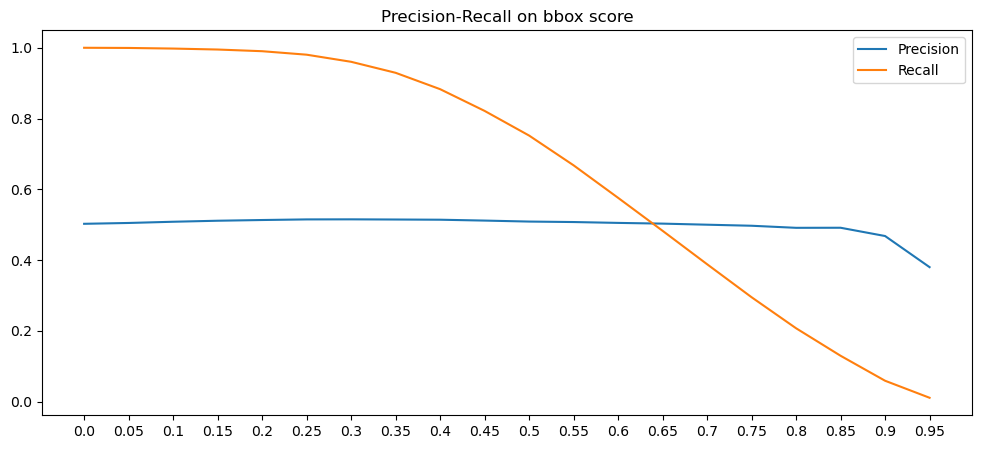

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.xticks(ticks=np.arange(0, 20), labels=[np.round(i,2) for i in np.linspace(0.0, 0.95, 20)])
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.title('Precision-Recall on bbox score')
plt.legend()
plt.show()

In [23]:
# Find threshold for knn distance
all_image_stats = []
for th in np.linspace(0.0, 0.95, 20):
    for img_name in classified_per_image_objects:
        image_stats = {'img_name': img_name, 'TH': th, 'FP': 0, 'TP': 0, 'FN': 0, 'Precision': 0.0, 'Recall': 0.0}
        image_pred_objects = classified_per_image_objects[img_name]
        for pred_objects in image_pred_objects:
            
            # Will consider that object if it belongs to the training
            if pred_objects.is_train is not None and pred_objects.is_train == False:
                continue
            
            if (pred_objects.pred_bbox is not None) and pred_objects.class_score is not None and (pred_objects.class_score < th):
                # Bounding box is found extra by the detection network
                if pred_objects.gt_bbox is None:
                    image_stats['FP'] += 1
                # Bounding box misclassified by the knn
                elif pred_objects.gt_label != pred_objects.pred_label:
                    image_stats['FP'] += 1
                # True detection
                elif pred_objects.gt_label == pred_objects.pred_label:
                    image_stats['TP'] += 1
            
            # Bounding box is missed by the detection network
            elif pred_objects.gt_label is not None:
                image_stats['FN'] += 1
        
        if (image_stats['TP'] + image_stats['FP']) > 0:
            image_stats['Precision'] = image_stats['TP'] / (image_stats['TP'] + image_stats['FP'])
        else:
            image_stats['Precision'] = None
            
        if (image_stats['TP'] + image_stats['FN']) > 0:
            image_stats['Recall'] = image_stats['TP'] / (image_stats['TP'] + image_stats['FN'])
        else:
            image_stats['Recall'] = None
            
        all_image_stats.append(image_stats)

In [24]:
precisions = []
recalls = []
metric_df = pd.DataFrame(all_image_stats)
for th in np.linspace(0.0, 0.95, 20):
    filtered_df = metric_df[metric_df['TH'] == th]
    mean_precision = filtered_df['Precision'].mean()
    mean_recall = filtered_df['Recall'].mean()
    precisions.append(mean_precision)
    recalls.append(mean_recall)

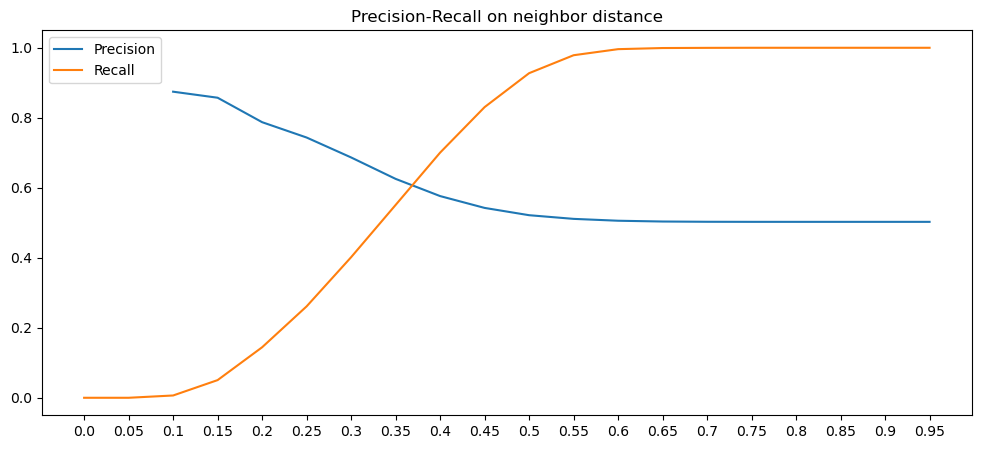

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.xticks(ticks=np.arange(0, 20), labels=[np.round(i,2) for i in np.linspace(0.0, 0.95, 20)])
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.title('Precision-Recall on neighbor distance')
plt.legend()
plt.show()

In [26]:
# KNN model with all classes and extracted train image features
knn = KNNClassifier(num_neighbor, similarity_metric=sim_metric)
knn.load_and_fit_RPC(knn_train_features_path, n_sample=num_sample)

  0%|          | 0/200 [00:00<?, ?it/s]

Loadded feature vector with shape: (1600, 384), label array with shape: (1600,)


In [27]:
# Load validation objects and classify them
val_pred_objects = read_pred_objects_json("/kaggle/input/di-lab-idea2-artifacts/Idea2-Files/Dino/vith_res_val_processed_pred_objects_2.json")

classified_pred_objects = []

for pred_object in tqdm(val_pred_objects):
    
    if pred_object.pred_features is not None:
        
        predicted_label = knn.predict_sample(pred_object.pred_features)
        predicted_sub_class = knn.label_to_class[predicted_label[0]]
        knn_mean_dist = knn.get_mean_dist_neighbors(pred_object.pred_features, predicted_label)

        pred_object.add_classification_res(predicted_sub_class, knn_mean_dist[0])        
        classified_pred_objects.append(pred_object)
        
classified_per_image_objects = get_pred_objects_per_image(classified_pred_objects)

  0%|          | 0/15679 [00:00<?, ?it/s]

In [28]:
# Use learned thresholds on validation set
class_score_th = 0.37
bbox_score_th = 0.2
# Find threshold for knn distance
all_image_stats = []
for img_name in classified_per_image_objects:
    image_stats = {'img_name': img_name, 'FP': 0, 'TP': 0, 'FN': 0, 'Precision': 0.0, 'Recall': 0.0}
    image_pred_objects = classified_per_image_objects[img_name]
    for pred_objects in image_pred_objects:

        # Will consider that object if it belongs to the training
        if pred_objects.is_train is not None and pred_objects.is_train == True:
            continue

        if (pred_objects.pred_bbox is not None) and (pred_objects.class_score is not None and pred_objects.class_score < class_score_th) and (pred_objects.pred_score_bbox is not None and pred_objects.pred_score_bbox > bbox_score_th): 
            # Bounding box is found extra by the detection network
            if pred_objects.gt_bbox is None:
                image_stats['FP'] += 1
            # Bounding box misclassified by the knn
            elif pred_objects.gt_label != pred_objects.pred_label:
                image_stats['FP'] += 1
            # True detection
            elif pred_objects.gt_label == pred_objects.pred_label:
                image_stats['TP'] += 1

        # Bounding box is missed by the detection network
        elif pred_objects.gt_label is not None:
            image_stats['FN'] += 1

    if (image_stats['TP'] + image_stats['FP']) > 0:
        image_stats['Precision'] = image_stats['TP'] / (image_stats['TP'] + image_stats['FP'])
    else:
        image_stats['Precision'] = None

    if (image_stats['TP'] + image_stats['FN']) > 0:
        image_stats['Recall'] = image_stats['TP'] / (image_stats['TP'] + image_stats['FN'])
    else:
        image_stats['Recall'] = None

    all_image_stats.append(image_stats)

In [29]:
metric_df = pd.DataFrame(all_image_stats)
mean_precision = metric_df['Precision'].mean()
mean_recall = metric_df['Recall'].mean()

In [30]:
print(mean_recall)

0.6469867255678988


In [31]:
print(mean_precision)

0.49412426747390076


In [32]:
import cv2
import matplotlib.pyplot as plt

def get_bboxes_from_txt(txtfile_path):
    bboxes = []
    with open(txtfile_path, 'r') as txtfile:
        lines = txtfile.readlines()
        for line in lines:
            splitted_lines = line.split(" ")
            bboxes.append([float(i) for i in splitted_lines[-4:]] + [splitted_lines[0]])
    return bboxes

def draw_bboxes(img_path, gt_boxes, pred_boxes):
    # Draw parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2
    thickness = 2
    text_color = (113, 24, 200)
    bbox_color = (12, 154, 242)
    
    org_img = cv2.imread(img_path)    
    org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
    
    gt_drawn_img = org_img.copy()
    pred_drawn_img = org_img.copy()
    
    for bbox in gt_boxes:
        start_x, start_y, bbox_w, bbox_h = [int(i) for i in bbox[:4]]
        label = bbox[-1]
        cv2.putText(gt_drawn_img, label, (start_x, start_y-10), font, font_scale, text_color, thickness)    
        cv2.rectangle(gt_drawn_img, (start_x, start_y), (start_x + bbox_w, start_y+bbox_h), bbox_color, 4)
        
    for bbox in pred_boxes:
        start_x, start_y, bbox_w, bbox_h = [int(i) for i in bbox[:4]]
        label = bbox[-1]
        cv2.putText(pred_drawn_img, label, (start_x, start_y-10), font, font_scale, text_color, thickness)    
        cv2.rectangle(pred_drawn_img, (start_x, start_y), (start_x + bbox_w, start_y+bbox_h), bbox_color, 4)
        
    return gt_drawn_img, pred_drawn_img

In [33]:
def export_per_img_pred_objects_with_th(per_image_pred_objects, gt_path, pred_path, bounding_box_th, class_score_th, use_base_classes=False):
    for img_name in per_image_pred_objects:
        txt_name = img_name.split('.')[0] + '.txt'
        pred_txt_dir = os.path.join(pred_path, txt_name)
        with open(pred_txt_dir, "w") as txtfile:
            for predict_object in per_image_pred_objects[img_name]:
                
                if predict_object.pred_bbox is not None and predict_object.pred_score_bbox > bounding_box_th and (predict_object.class_score is not None and predict_object.class_score < class_score_th):
                    label = predict_object.pred_label
                    if use_base_classes:
                        label = ''.join(label.split('_')[1:])
                    x1, y1, x2, y2 = predict_object.pred_bbox
                    conf = predict_object.pred_score_bbox
                    txtfile.write("{} {} {} {} {} {}\n".format(label, conf, x1, y1, x2-x1, y2-y1))

        gt_txt_dir = os.path.join(gt_path, txt_name)
        with open(gt_txt_dir, "w") as txtfile:
            for predict_object in per_image_pred_objects[img_name]:
                
                if predict_object.gt_bbox is not None:
                    label = predict_object.gt_label
                    if use_base_classes:
                        label = ''.join(label.split('_')[1:])                    
                    x1, y1, w, h = predict_object.gt_bbox
                    # GT bbox is in the form of xywh
                    txtfile.write("{} {} {} {} {}\n".format(label, x1, y1, w, h))

In [34]:
!mkdir '../val_gt_full'
!mkdir '../val_pred_full'
export_per_img_pred_objects_with_th(classified_per_image_objects, '../val_gt_full', '../val_pred_full', bbox_score_th, class_score_th)
!python "evaluation/object-detection-metrics/evaluate.py" -gt "../val_gt_full/" -det "../val_pred_full/" -sp "../val_eval_full"

Average precision values per class for the whole images:

Class: 100_milk: AP: 0.128571
Class: 100_milk: Recall: 0.150000 Precision: 0.857143
Class: 101_milk: AP: 0.132075
Class: 101_milk: Recall: 0.169811 Precision: 0.750000
Class: 102_milk: AP: 0.265385
Class: 102_milk: Recall: 0.269231 Precision: 0.933333
Class: 103_milk: AP: 0.059211
Class: 103_milk: Recall: 0.125000 Precision: 0.450000
Class: 104_milk: AP: 0.207932
Class: 104_milk: Recall: 0.280488 Precision: 0.676471
Class: 105_milk: AP: 0.625773
Class: 105_milk: Recall: 0.723077 Precision: 0.824561
Class: 106_milk: AP: 0.261530
Class: 106_milk: Recall: 0.361111 Precision: 0.650000
Class: 107_milk: AP: 0.155330
Class: 107_milk: Recall: 0.403509 Precision: 0.315068
Class: 108_canned_food: AP: 0.248853
Class: 108_canned_food: Recall: 0.296296 Precision: 0.470588
Class: 109_canned_food: AP: 0.245014
Class: 109_canned_food: Recall: 0.291667 Precision: 0.807692
Class: 10_puffed_food: AP: 0.043784
Class: 10_puffed_food: Recall: 0.24324

In [35]:
!mkdir '../val_gt_full_base'
!mkdir '../val_pred_full_base'
export_per_img_pred_objects_with_th(classified_per_image_objects, '../val_gt_full_base', '../val_pred_full_base', bbox_score_th, class_score_th, True)
!python "evaluation/object-detection-metrics/evaluate.py" -gt "../val_gt_full_base/" -det "../val_pred_full_base/" -sp "../val_eval_full_base"

Average precision values per class for the whole images:

Class: alcohol: AP: 0.266659
Class: alcohol: Recall: 0.275061 Precision: 0.933610
Class: candy: AP: 0.349934
Class: candy: Recall: 0.718056 Precision: 0.446845
Class: cannedfood: AP: 0.310298
Class: cannedfood: Recall: 0.326039 Precision: 0.928349
Class: chocolate: AP: 0.504421
Class: chocolate: Recall: 0.584416 Precision: 0.854430
Class: dessert: AP: 0.588595
Class: dessert: Recall: 0.681137 Precision: 0.859562
Class: driedfood: AP: 0.601311
Class: driedfood: Recall: 0.652705 Precision: 0.855835
Class: driedfruit: AP: 0.632418
Class: driedfruit: Recall: 0.833333 Precision: 0.732484
Class: drink: AP: 0.279359
Class: drink: Recall: 0.306220 Precision: 0.788501
Class: gum: AP: 0.528374
Class: gum: Recall: 0.676636 Precision: 0.751037
Class: instantdrink: AP: 0.389837
Class: instantdrink: Recall: 0.499332 Precision: 0.733333
Class: instantnoodles: AP: 0.728799
Class: instantnoodles: Recall: 0.831776 Precision: 0.869353
Class: milk:

In [36]:
results_df = pd.read_csv('../val_eval_full/eval_results_per_image.csv')
groupped_df = results_df.groupby(['class']).mean(numeric_only=True)
groupped_df.mean()

AP            0.426595
TP            0.608092
FP            0.265197
Recall        0.430232
Precision     0.406292
GT Objects    1.479173
dtype: float64

In [37]:
results_df = pd.read_csv('../val_eval_full_base/eval_results_per_image.csv')
groupped_df = results_df.groupby(['class']).mean(numeric_only=True)
groupped_df.mean()

AP            0.531514
TP            1.020825
FP            0.287521
Recall        0.547220
Precision     0.549495
GT Objects    1.892016
dtype: float64

In [38]:
filtered_results_df = results_df[~results_df['AP'].isna()]
ap_sorted_df = filtered_results_df.sort_values(by=['Precision', 'Recall'])

In [39]:
!mkdir 'figures_new'

In [40]:
len(ap_sorted_df)

6398

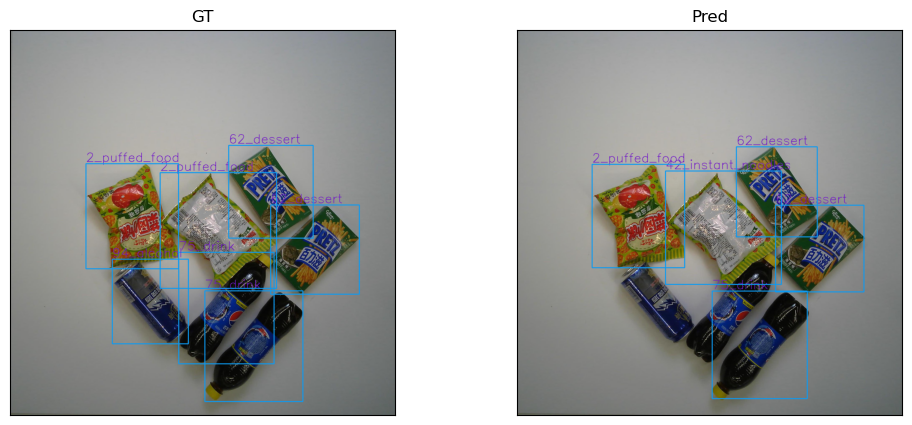

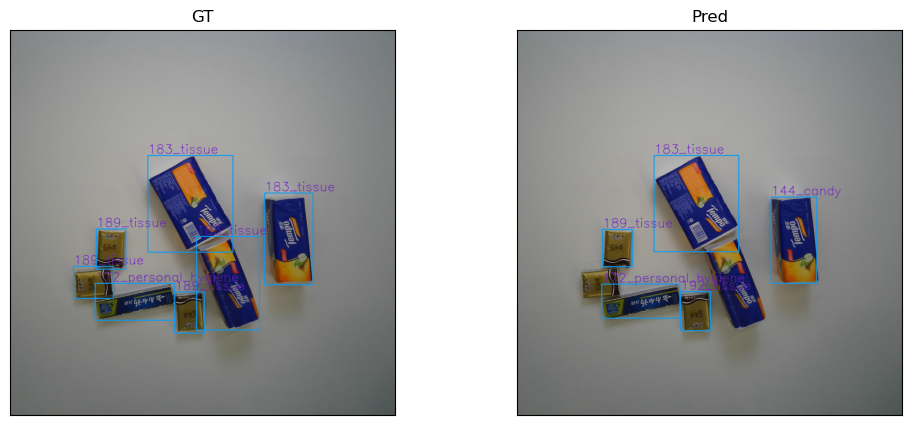

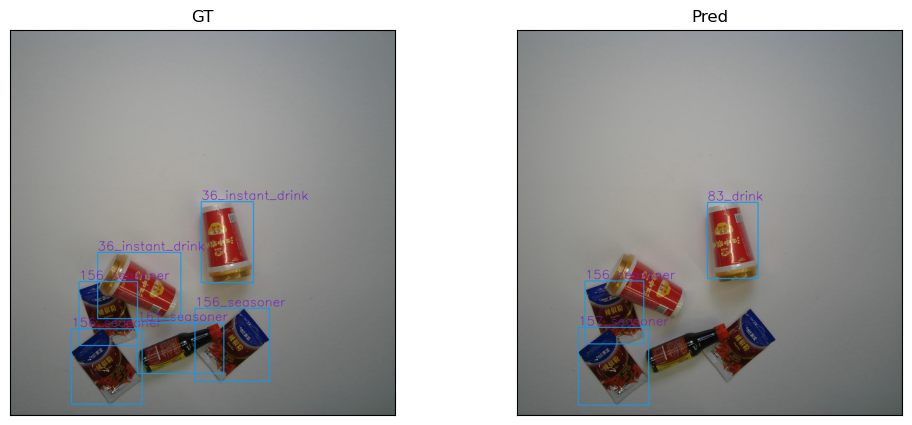

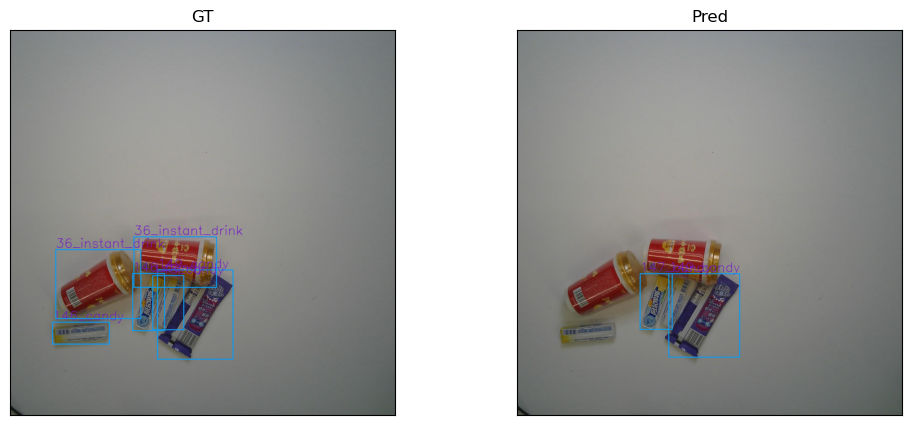

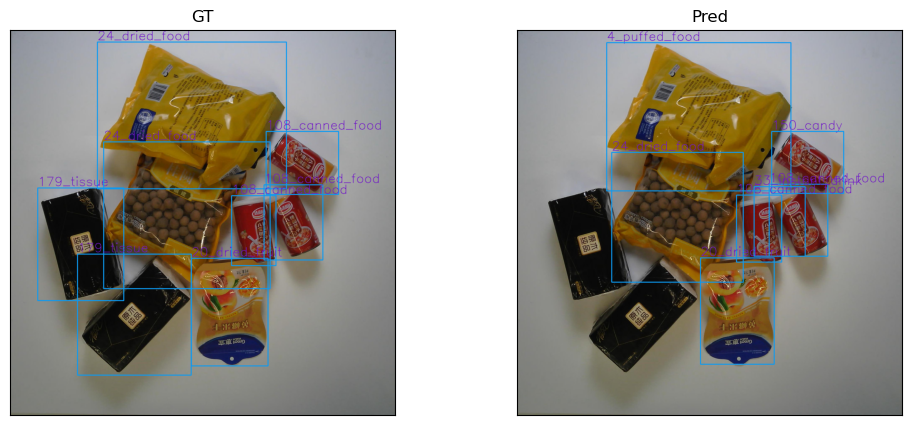

In [41]:
gt_annots_folder_path = '../val_gt_full'
pred_annots_folder_path = '../val_pred_full'

for i, row in ap_sorted_df[3024:3029].iterrows():
    img_name = row['img_name']
    txt_name = img_name + '.txt'
    
    pred_txt_path = os.path.join(pred_annots_folder_path, txt_name)
    gt_txt_path = os.path.join(gt_annots_folder_path, txt_name)
    
    pred_boxes = get_bboxes_from_txt(pred_txt_path)
    gt_boxes = get_bboxes_from_txt(gt_txt_path)
    img_path = os.path.join('/kaggle/input/retail-product-checkout-dataset/val2019/', img_name + '.jpg')
    
    gt_img, pred_img = draw_bboxes(img_path, gt_boxes, pred_boxes)
    
    fig, axis = plt.subplots(1, 2, figsize=(12, 5))
    
    #fig.suptitle("Precision: {:.2f}, Recall: {:.2f}".format(row['Precision'], row['Recall']))
    
    axis[0].imshow(gt_img)
    axis[0].set_title('GT')
    axis[0].set_xticks([])
    axis[0].set_yticks([])
    
    axis[1].imshow(pred_img)
    axis[1].set_title('Pred')
    axis[1].set_xticks([])
    axis[1].set_yticks([])
    
    plt.savefig("figures_new/res_{}".format(i))
    plt.show()

In [42]:
!mkdir '../figures_new'
!cp -a 'figures_new' '../figures_new'

In [43]:
!zip -r '../figures_new.zip' '../figures_new'

  adding: ../figures_new/ (stored 0%)
  adding: ../figures_new/figures_new/ (stored 0%)
  adding: ../figures_new/figures_new/res_145.png (deflated 1%)
  adding: ../figures_new/figures_new/res_148.png (deflated 1%)
  adding: ../figures_new/figures_new/res_153.png (deflated 1%)
  adding: ../figures_new/figures_new/res_122.png (deflated 1%)
  adding: ../figures_new/figures_new/res_157.png (deflated 1%)
